In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


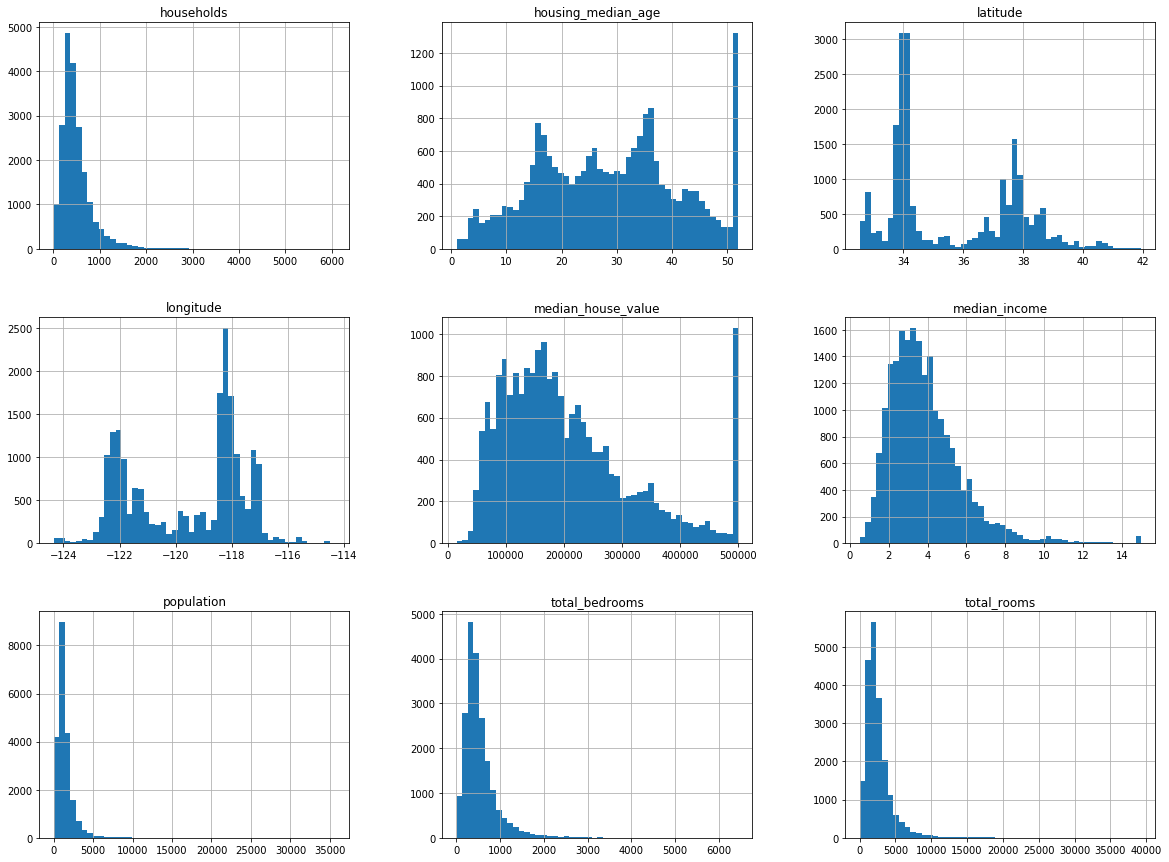

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Test set

In [11]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)* test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, .20)
len(train_set)

16512

In [13]:
len(test_set)

4128

#### Using specific identifiers to separate (could add a random seed)

In [14]:
from zlib import crc32 

def test_set_check(identifier, test_ratio): 
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [15]:
def split_train_test_by_id(data, test_ratio, id_column): 
    ids = data[id_column] 
    in_test_set = ids.apply( lambda id_: test_set_check(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

#### Index is identifier

In [16]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

#### Stable features are identifiers

In [19]:
housing_with_id["id"]=housing["longitude"] *1000 +housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

#### Scikit learn thing

In [20]:
from sklearn.model_selection import train_test_split 

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

#### Dividing into categories to ensure that the test set is representative of an important category

In [21]:
#In this case, median income

housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0.,1.5,3.0,4.5,6.0,np.inf],
                              labels=[1,2,3,4,5])

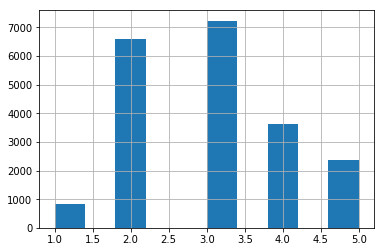

In [23]:
housing["income_cat"].hist()

#### Stratified sampling

In [34]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    

In [35]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [36]:
# Check table in pg. 53 to see how the proportions are kept by strata, thefore preventing sampling bias in the feature of interest 

#### Removing income_cat column so that the data is just as I found it

In [38]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and visualize the data to gain insights

In [39]:
#copy of the training set to explore and play wo harming the set

housing = strat_train_set.copy()

### Visualizing the geografic data

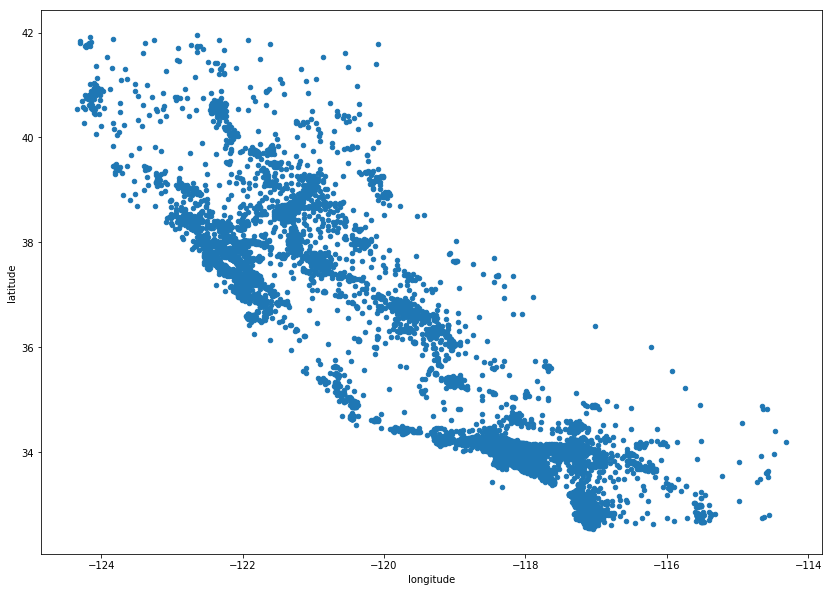

In [61]:
housing.plot(kind="scatter",x="longitude",y="latitude",figsize=(14,10))
#This type of plot is for pandas

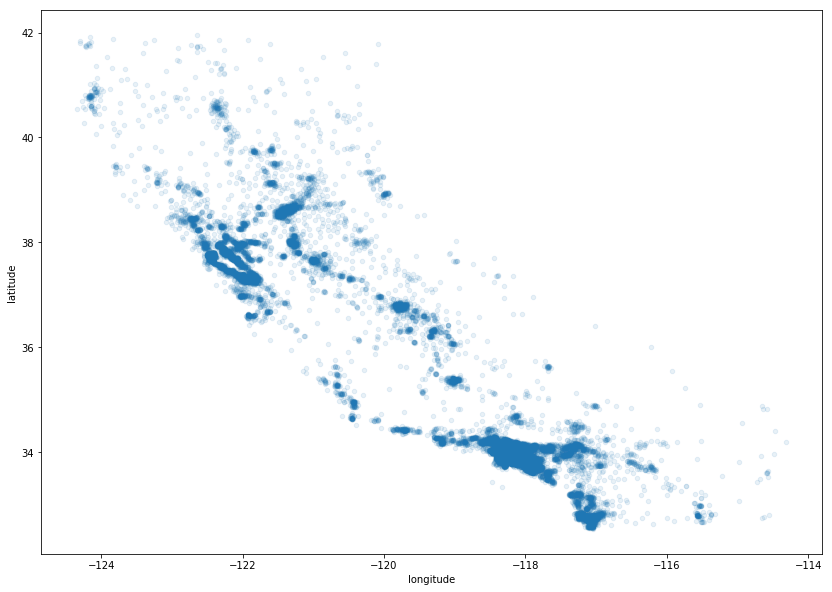

In [62]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1,figsize=(14,10))
#Alpha parameter gives a better idea of density


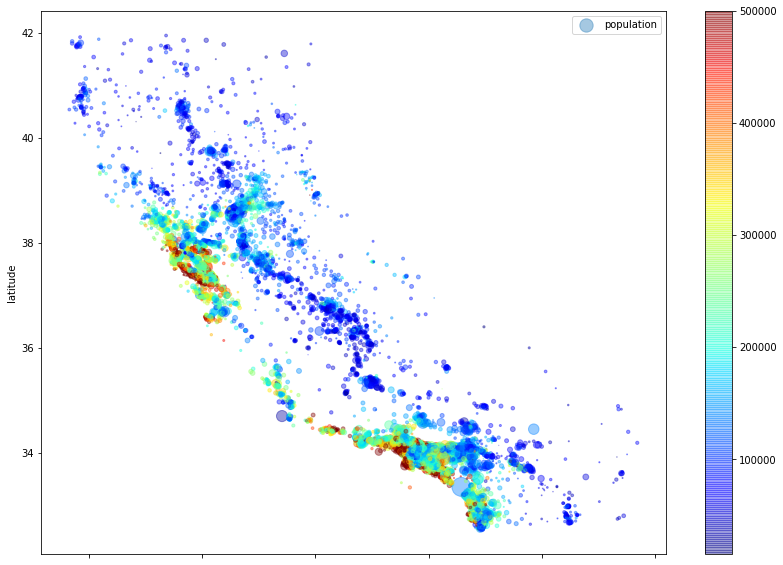

In [81]:
%matplotlib inline
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
             figsize=(14,10),s=housing["population"]/100, label="population",
             c=housing["median_house_value"], cmap=plt.get_cmap("jet"),colorbar=True,)
plt.legend()
plt.show()

## Looking for correlations

In [83]:
#Standard correlation or Pearson's r

corr_matrix = housing.corr()

In [87]:
corr_matrix["median_house_value"].sort_values(ascending=False)
#This is just LINEAR correlation

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

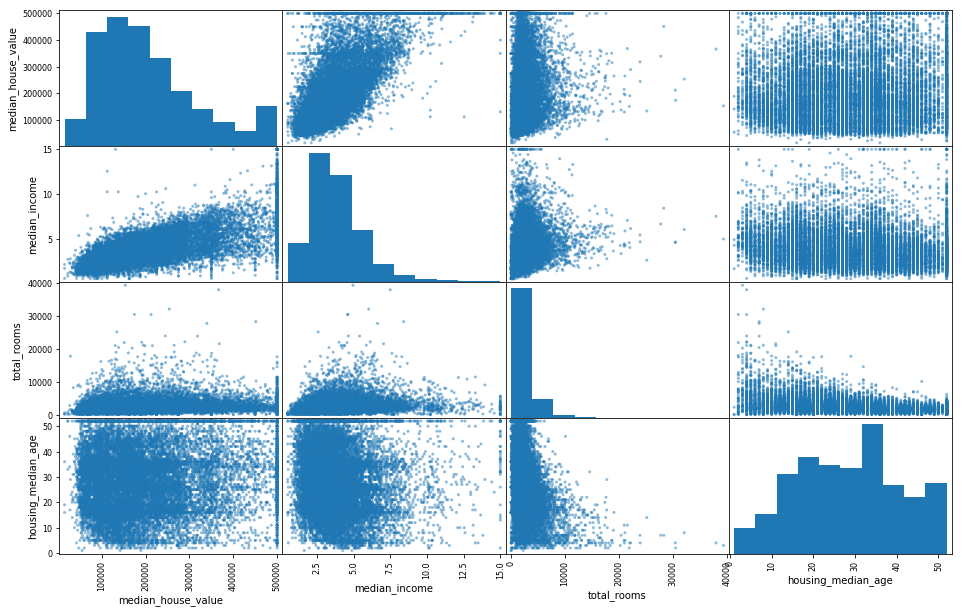

In [92]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(16,10))
plt.show()

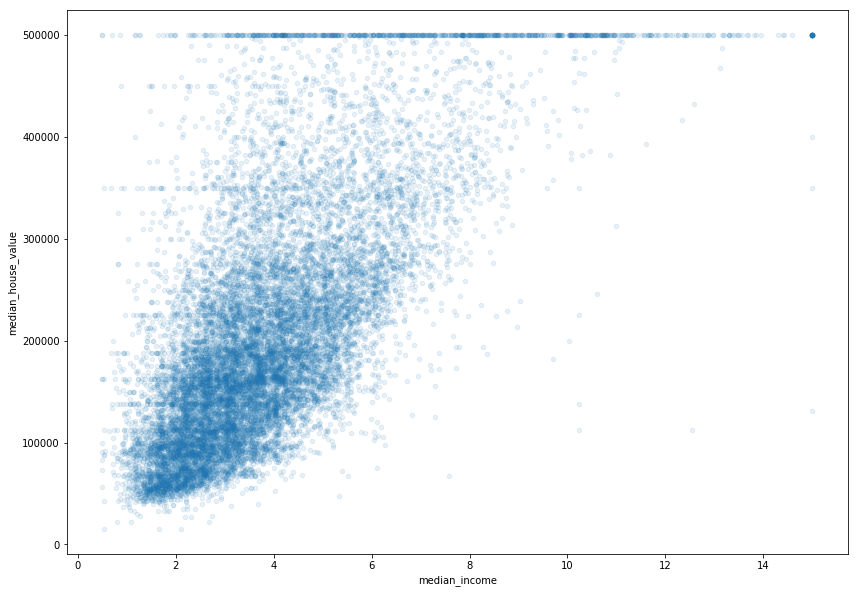

In [94]:
#Median_house_value and median_income seem to correlate 

housing.plot(kind="scatter", x="median_income",y="median_house_value",alpha=0.1,figsize=(14,10))
plt.show()

In [95]:
#There are weird horizontal lines at several values that might ruin things up for us 
#so we might consider removing those districts

## Experimenting with attribute combinations